<div class="alert alert-block alert-info">
<b>Deadline:</b> March 23, 2022 (Wednesday) 23:00
</div>

# Exercise 2. Recommender system

In this exercise, your task is to design a recommender system.

## Learning goals:
* Practise tuning a neural network model by using different regularization methods.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tools
import data

In [2]:
skip_training = True  # Set this flag to True before validation and submission

In [3]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Ratings dataset

We will train the recommender system on the dataset in which element consists of three values:
* `user_id` - id of the user (the smallest user id is 1)
* `item_id` - id of the movie (the smallest item id is 1)
* `rating` - rating given by the user to the item (ratings are integer numbers between 1 and 5.

The recommender system need to predict the rating for any given pair of `user_id` and `item_id`.

We measure the quality of the predicted ratings using the mean-squared error (MSE) loss:
$$
  \frac{1}{N}\sum_{i=1}^N (r_i - \hat{r}_i)^2
$$
where $r_i$ is a real rating and $\hat{r}_i$ is a predicted one.

Note: The predicted rating $\hat{r}_i$ does not have to be an integer number.

In [7]:
trainset = data.RatingsData(root=data_dir, train=True)
testset = data.RatingsData(root=data_dir, train=False)

In [8]:
# Print one sample from the dataset
x = trainset[0]
print(f'user_id={x[0]}, item_id={x[1]}, rating={x[2]}')

user_id=1, item_id=1, rating=5


# Model

You need to design a recommender system model with the API described in the cell below.

Hints on the model architecture:
* You need to use [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding) layer to convert inputs `user_ids` and `item_ids` into reasonable representations. The idea of the embedding layer is that we want to represent similar users with values that are close to each other. The original representation as integers is not good for that. By using the embedding layer, we can learn such useful representations automatically.

### Model tuning

In this exercise, you need to tune the architecture of your model to achieve the best performance on the provided test set. You will notice that overfitting is a severe problem for this data: The model can easily overfit the training set producing poor accuracy on the out-of-training (test) data.

You need to find an optimal combination of the hyperparameters, with some hyperparameters corresponding to the regularization techniques that we studied in the lecture.

The hyperparameters that you are advised to consider:
* Learning rate value and learning rate schedule (decresing the learning rate often has positive effect on the model performance)
* Number of training epochs
* Network size
* Weight decay
* Early stopping
* Dropout
* Increase amount of data:
  * Data augmentation
  * Injecting noise

You can tune the hyperparameters by, for example, grid search, random search or manual tuning. In that case, you can use `architecture` argument to specify the hyperparameters that define the architecture of your network. After you have tuned the hyperparameters, set the default value of this argument to the optimal set of the hyparameters so that the best architecture is used in the accuracy tests.

Note:
* The number of points that you will get from this exercise depends on the MSE loss on the test set:
  * below 1.00: 1 point
  * below 0.95: 2 points
  * below 0.92: 3 points
  * below 0.90: 4 points
  * below 0.89: 5 points
  * below 0.88: 6 points 

In [9]:
class RecommenderSystem(nn.Module):
    def __init__(self, n_users, n_items,
                 architecture=None  # If you want to tune the hyperparameters automatically (e.g. using random
                                    # search), use this argument to specify the hyperparameters that define the
                                    # architecture of your network. After you have tuned the hyperparameters,
                                    # set the default value of this argument to the optimal set of the hyparameters
                                    # so that the best architecture is used in the accuracy tests.
                ):
        """
        Args:
          n_users: Number of users.
          n_items: Number of items.
        """
        # YOUR CODE HERE
        super().__init__()
        embedding_dim = 10
        print("n_users: ",n_users)
        self.user_embedding = torch.nn.Embedding(n_users+1, embedding_dim)
        self.item_embedding = torch.nn.Embedding(n_items+1, embedding_dim)
        self.L1=nn.Linear(embedding_dim*2,10)
        self.A1=nn.ReLU()
        
        self.dropout=nn.Dropout(p=0.5)
        self.L2=nn.Linear(10,10)
        self.A2=nn.ReLU()
        self.dropout=nn.Dropout(p=0.5)
        
        self.L3=nn.Linear(10,1)
        
        #raise NotImplementedError()
        
    def forward(self,user_ids, item_ids):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).
        
        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        # YOUR CODE HERE
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = torch.cat([user_embedding, item_embedding], 1)
        
        x=self.L1(x)
        x=self.A1(x)
        #x=self.dropout(x)
        #x=self.L2(x)
        #x=self.A2(x)
        #x=self.dropout(x)
        x=self.L3(x)
        x=torch.sigmoid(x)*5
        #print(x)
        x=torch.flatten(x)
        
        output=x
        #print("output: ", output,"  torchsize： ",torch.Size([10]))
        return output
        raise NotImplementedError()

You can test the shapes of the model outputs using the function below.

In [10]:
def test_RecommenderSystem_shapes():
    n_users, n_items = 100, 1000
    model = RecommenderSystem(n_users, n_items)
    batch_size = 10
    user_ids = torch.arange(1, batch_size+1)
    item_ids = torch.arange(1, batch_size+1)
    output = model(user_ids, item_ids)
    print(output.shape)
    assert output.shape == torch.Size([batch_size]), "Wrong output shape."
    print('Success')

test_RecommenderSystem_shapes()

n_users:  100
torch.Size([10])
Success


In [11]:
# This cell is reserved for testing

## Train the model

You need to train a recommender system using **only the training data.** Please use the test set to select the best model: the model that generalizes best to out-of-training data.

**IMPORTANT**:
* During testing, the predictions are produced by `predictions = model(user_ids, item_ids)` with the `user_ids` and `item_ids` loaded from `RatingsData`.
* There is a size limit of 30Mb for saved models.

In [12]:
# Create the model
# IMPORTANT: the default value of the architecture argument should define your best model.
model = RecommenderSystem(trainset.n_users, trainset.n_items)

n_users:  943


In [13]:
# My Code Here
def compute_loss(mlp, user_ids, item_ids, y ):
    mlp.eval()
    with torch.no_grad():
        outputs = mlp(user_ids, item_ids)
        loss = F.mse_loss(outputs, y)
        return loss.cpu().numpy()

# This is the function to print the progress during training
def print_progress(epoch, train_error, val_error):
    print('Epoch {}: Train error: {:.4f}, Test error: {:.4f}'.format(
        epoch, train_error, val_error))

In [14]:
# My Code Here
user_id = torch.tensor(trainset)[:,0]-1
item_id = torch.tensor(trainset)[:,1]-1
rate_id = torch.tensor(trainset)[:,2]
# user_ids == user_id

user_id_test = torch.tensor(testset)[:,0]-1
item_id_test = torch.tensor(testset)[:,1]-1
rate_id_test = torch.tensor(testset)[:,2]
torch.tensor(trainset)
#x_train

tensor([[   1,    1,    5],
        [   1,    2,    3],
        [   1,    4,    3],
        ...,
        [ 943, 1067,    2],
        [ 943, 1074,    4],
        [ 943, 1188,    3]])

In [15]:
#My code here
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).
                 
                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)
    


Epoch 9: Train error: 0.8592, Test error: 0.8982
Epoch 19: Train error: 0.8060, Test error: 0.8744
Epoch 29: Train error: 0.7953, Test error: 0.8703


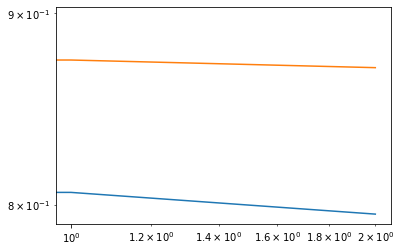

In [16]:
# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    
    model.train()
    #criterion = nn.CrossEntropyLoss()
    n_epochs = 30  # Total 80,000
    batchsize = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    criterion = nn.MSELoss() 
    train_errors = []  # Keep track of the training data
    val_errors = []
    
    # Early stop
    early_stop = EarlyStopping(tolerance=0.01, patience=20)
    

    
    for i in range(n_epochs):
        #print("Number of epoch: ", i)
        
        for batch in range(int(len(trainset)/batchsize)-1):
            index = np.arange(batch*batchsize,(batch+1)*batchsize )
            user = user_id[index]
            item = item_id[index]
            rate = rate_id[index]
            
            optimizer.zero_grad()
            predictions = model.forward(user, item)
            loss = criterion(predictions.to(torch.float32), rate.to(torch.float32))
            
            #output=output.to(torch.float32)
            loss.backward()
            optimizer.step()
            
        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break

            
        #print(loss)
        if (i+1) % 10 == 0:
            model.eval()
            #print(user_id, item_id, rate_id)
            #import pdb;pdb.set_trace()
            train_errors.append(compute_loss(model,user_id, item_id, rate_id))
            
            val_errors.append(compute_loss(model, user_id_test, item_id_test, rate_id_test ))
            print_progress(i, train_errors[-1], val_errors[-1])
            
    # Draw a Figure        
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)
    #raise NotImplementedError()
    
    


In [17]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(model, 'recsys.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to recsys.pth.


In [18]:
# This cell loads your best model
if skip_training:
    model = RecommenderSystem(trainset.n_users, trainset.n_items)
    tools.load_model(model, 'recsys.pth', device)

The next cell tests the accuracy of your best model. It is enough to submit .pth files.

**IMPORTANT**:
* During testing, the predictions are produced by `predictions = model(user_ids, item_ids)` with the `user_ids` and `item_ids` loaded from `RatingsData`.
* There is a size limit of 30Mb for saved models. Please make sure that your model loads in the cell above.

In [19]:
# This cell tests the accuracy of your best model.

In [20]:
# This cell is reserved for grading

In [21]:
# This cell is reserved for grading

In [22]:
# This cell is reserved for grading

In [23]:
# This cell is reserved for grading

In [24]:
# This cell is reserved for grading

In [25]:
# This cell is reserved for grading